In [2]:
import janitor
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd. set_option('display.max_columns', None)
pd. set_option('display.max_rows', 70)
sns.set(rc={'figure.figsize':(15,10)})
import warnings
warnings.filterwarnings("ignore")

module_path = os.path.abspath(os.path.join(''))
if module_path not in sys.path:
    sys.path.append(module_path+"/python_sql/")

pd.set_option('display.max_colwidth', None)
import json
from datetime import datetime,timedelta

# loan-transaction_data

In [3]:
# from connect_sql import ConnectSQL
# connect_obj = ConnectSQL()
# df = connect_obj.query_db("""
# select 
# 	l.customer_id,
# 	c.created registration_date,
# 	l.creation_date loan_start_date,
#     l.merchant_id,
# 	l.id loan_id,t.scheduled_payment_date,t.status,t.payment_date ,
# 	count(*) over (partition by t.loan_id order by t.scheduled_payment_date ) trans_num,
# 	case when m.cat_integration_type_code in ('API','POSUI') then 'Offline' else 'Online' end channel
# 	from loan l 
# 	join customer c on c.id=l.customer_id 
# 	join transaction t on t.loan_id =l.id
# 	left join merchant m on m.id=l.merchant_id 
# 	where l.status in('HISTORICAL', 'LATE','OUTSTANDING','DEFAULTED') 
# 	and l.customer_id is not null
#     and m.cat_integration_type_code not in ('API','POSUI'); """)
# df.to_csv("data/transactions_raw_data_20220503.csv")

In [4]:
trans=pd.read_csv("data/transactions_raw_data_20220503.csv",index_col=0)

In [5]:
# trans

In [6]:
trans['scheduled_payment_date']=pd.to_datetime(pd.to_datetime(trans['scheduled_payment_date']).dt.date)
trans['payment_date']=pd.to_datetime(pd.to_datetime(trans['payment_date']).dt.date)

# online loans

In [7]:
trans=trans[(trans['channel']=='Online')]   

**when payment date is null**

In [8]:
curr_date=pd.to_datetime(pd.datetime.today())

In [9]:
trans['payment_date']=trans.apply(lambda x: x.payment_date if pd.notnull(x.payment_date)  else curr_date,axis=1)

# on 1st_install (excluding downpayment)  7day delay

**for changing delay time chg to_timedelta condition**

In [39]:
trans['instal_1_late_pay']= (np.where(((trans['trans_num']==2)&
                                        (trans['scheduled_payment_date']<
                                         trans['payment_date']-pd.to_timedelta(5,'d'))),1,0))

In [40]:
instal_1_late_trans=trans.groupby(['loan_id','loan_start_date']).agg({'instal_1_late_pay':'sum'}).reset_index()

# shifting the dates forward

In [41]:
# fst_instl_date=pd.read_csv("data/transactions_raw_data_20220503.csv",index_col=0)

# fst_instl_date=fst_instl_date[fst_instl_date['trans_num']==2][['loan_id','scheduled_payment_date']]

# instal_1_late_trans=pd.merge(instal_1_late_trans,fst_instl_date,on='loan_id',how='inner')

# instal_1_late_trans['scheduled_payment_date']=pd.to_datetime(pd.to_datetime(instal_1_late_trans['scheduled_payment_date']).dt.date)
# instal_1_late_trans['loan_start_date']=instal_1_late_trans['scheduled_payment_date']+pd.to_timedelta(8,'d')

# print(instal_1_late_trans['instal_1_late_pay'].value_counts())
# instal_1_late_trans.to_csv("data/instal_1_late_trans.csv",index=0)

# plot

In [48]:
instal_1_late_trans['loan_start_date']=pd.to_datetime(pd.to_datetime(instal_1_late_trans['loan_start_date']).dt.date)

# set date range

In [49]:
instal_1_late_trans=instal_1_late_trans[instal_1_late_trans['loan_start_date']>'2022-01-01']

In [50]:
instal_1_late_trans=instal_1_late_trans.groupby(['loan_start_date']).agg({'instal_1_late_pay':'sum','loan_id':'count'}).reset_index()

In [51]:
instal_1_late_trans['delay_rate']=instal_1_late_trans['instal_1_late_pay']/instal_1_late_trans['loan_id']

([<matplotlib.axis.XTick at 0x1dd1c05b8c8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  

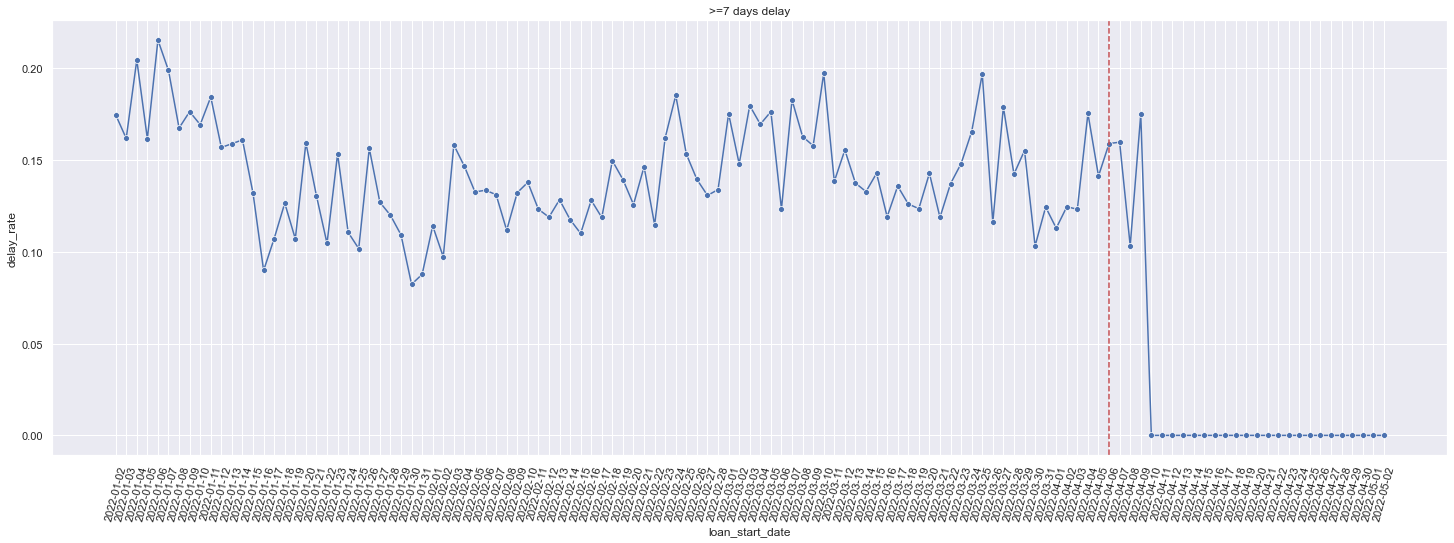

In [24]:
plt.figure(figsize=(25,8))
sns.lineplot(data=instal_1_late_trans,x='loan_start_date',y='delay_rate', marker='o')
plt.title(">=7 days delay")
plt.axvline(pd.Timestamp('2022-04-06'),color='r',linestyle='--')
plt.xticks(rotation='75')
plt.xticks(instal_1_late_trans['loan_start_date'])

([<matplotlib.axis.XTick at 0x1dd16f1a948>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  

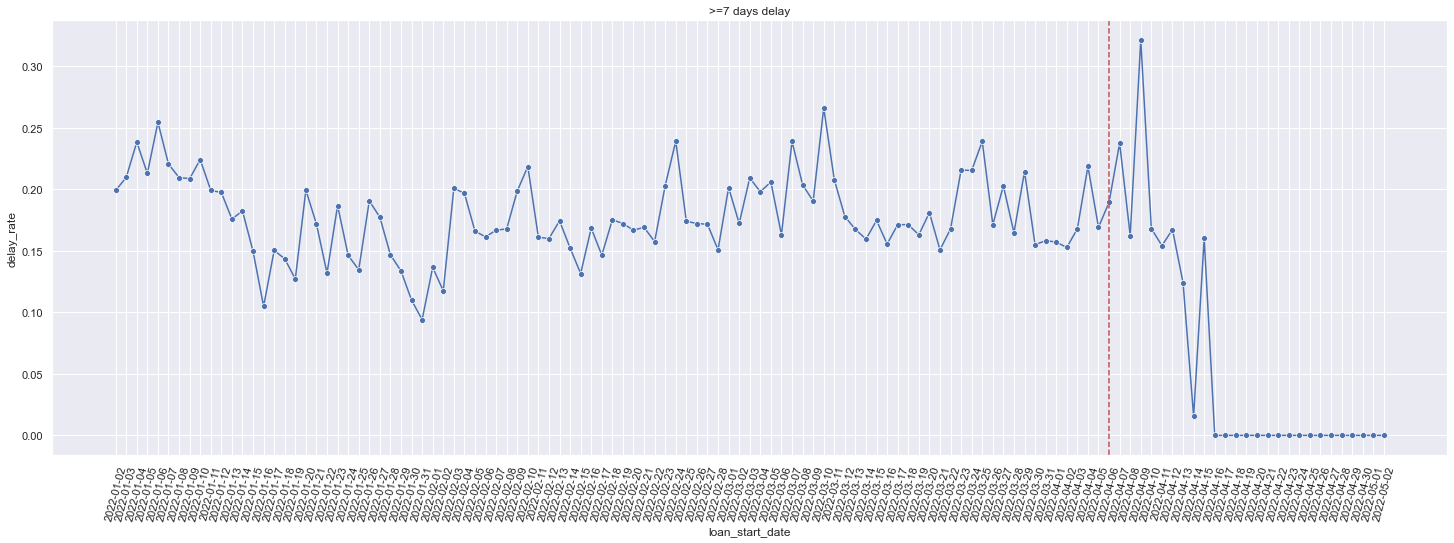

In [38]:
plt.figure(figsize=(25,8))
sns.lineplot(data=instal_1_late_trans,x='loan_start_date',y='delay_rate', marker='o')
plt.title(">=3 days delay")
plt.axvline(pd.Timestamp('2022-04-06'),color='r',linestyle='--')
plt.xticks(rotation='75')
plt.xticks(instal_1_late_trans['loan_start_date'])

([<matplotlib.axis.XTick at 0x1dd175684c8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  

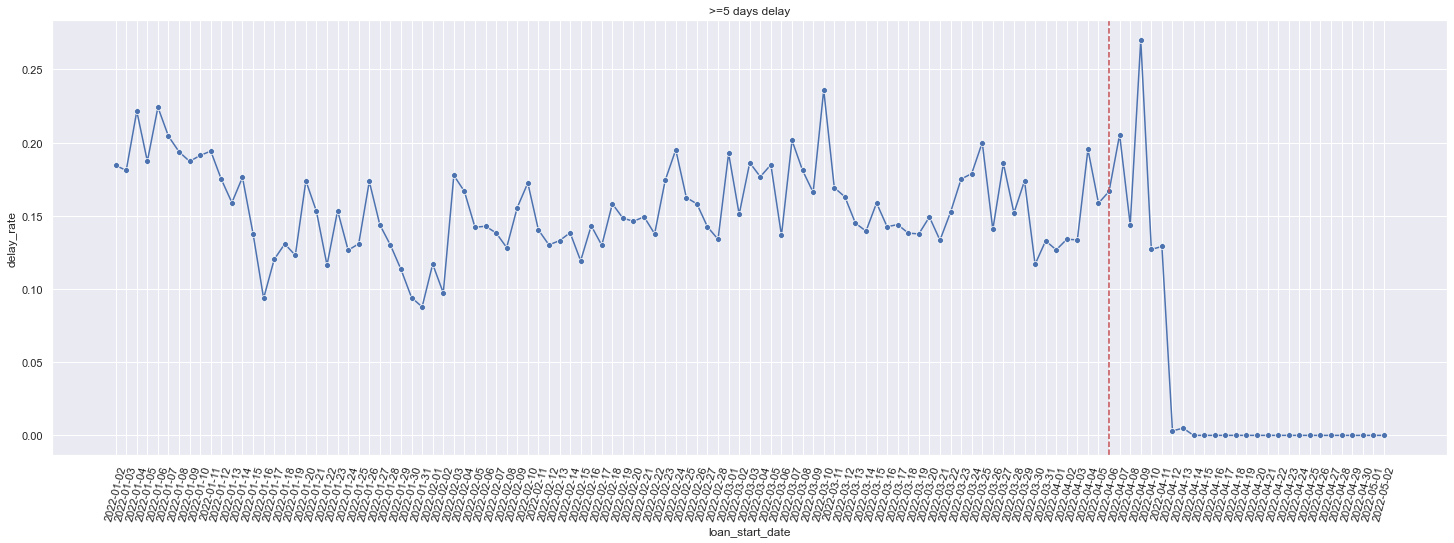

In [52]:
plt.figure(figsize=(25,8))
sns.lineplot(data=instal_1_late_trans,x='loan_start_date',y='delay_rate', marker='o')
plt.title(">=5 days delay")
plt.axvline(pd.Timestamp('2022-04-06'),color='r',linestyle='--')
plt.xticks(rotation='75')
plt.xticks(instal_1_late_trans['loan_start_date'])